The problem is maximum clique, i.e. find the largest clique in the graph
First, we need to convert the problem to a QUBO
We follow the approach in Lucas et al. 2014

First, we define the problem as a binary optimization problem
We have a binary variable for each node in the graph
The Hamiltonian is:
$$ H_\text{MC} = -A \sum_{v\in V} x_v + B \sum_{(u, v) \in \bar{E}} x_u x_v $$

$x_v$ is 0 if the vertex belongs to the clique and 0 if not.

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx import gnm_random_graph
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

from qubovert.utils import solve_qubo_bruteforce as qubo_solver


import pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice, MockDevice  
from pulser.waveforms import InterpolatedWaveform, BlackmanWaveform

import sys
sys.path.append('..')

from source.qubo import solve_qubo_bruteforce, plot_distribution, anneal, draw_solutions, evaluate_mapping, get_Q_from_coords, get_register_embedding
from source.qubovert_custom import problem_to_qubo_matrix

In [276]:
from itertools import combinations

def max_clique_qubo(graph, A=1.0, B=2.0):
    nodes = list(graph.nodes)
    N = len(nodes)
    Q = np.zeros((N, N))
    edges = list(graph.edges)
    
    # Set diagonal terms: -A * x_i
    for i in range(N):
        Q[i, i] = -A
    
    # Build the complement edge set
    all_pairs = combinations(nodes, 2)
    for i, j in all_pairs:
        if (i, j) not in edges and (j, i) not in edges:
            Q[i, j] = B
            Q[j, i] = B
    
    return Q

In [278]:
graph = gnm_random_graph(8, 14, seed=1337)
Q = max_clique_qubo(graph, A=1.0, B=2.0)
Q

array([[-1.,  0.,  2.,  0.,  0.,  2.,  0.,  2.],
       [ 0., -1.,  2.,  0.,  2.,  0.,  2.,  2.],
       [ 2.,  2., -1.,  2.,  2.,  0.,  2.,  2.],
       [ 0.,  0.,  2., -1.,  0.,  2.,  0.,  0.],
       [ 0.,  2.,  2.,  0., -1.,  0.,  2.,  0.],
       [ 2.,  0.,  0.,  2.,  0., -1.,  0.,  0.],
       [ 0.,  2.,  2.,  0.,  2.,  0., -1.,  2.],
       [ 2.,  2.,  2.,  0.,  0.,  0.,  2., -1.]])

In [279]:
solutions = solve_qubo_bruteforce(Q, n=5)
solutions

[(array([0, 0, 0, 0, 1, 1, 0, 1]), -3.0),
 (array([0, 0, 0, 1, 1, 0, 0, 1]), -3.0),
 (array([1, 0, 0, 1, 0, 0, 1, 0]), -3.0),
 (array([1, 0, 0, 1, 1, 0, 0, 0]), -3.0),
 (array([1, 1, 0, 1, 0, 0, 0, 0]), -3.0)]

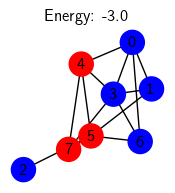

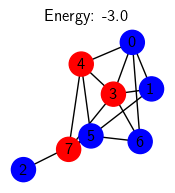

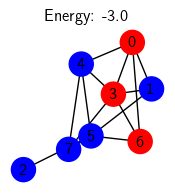

In [280]:
for s in solutions[:3]:
    color_map = []
    for node in graph:
        if s[0][node] == 1:
            color_map.append('red')
        else:
            color_map.append('blue')
    fig, ax = plt.subplots(figsize=(2,2))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, node_color=color_map, with_labels=True, ax=ax, pos=pos)
    plt.title(f"Energy: {s[1]}")
    plt.show()

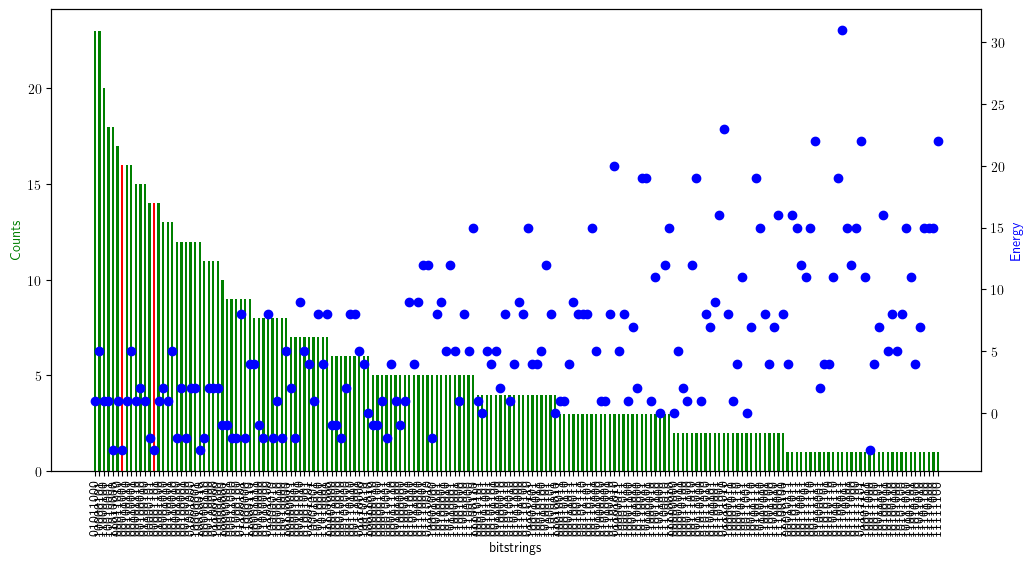

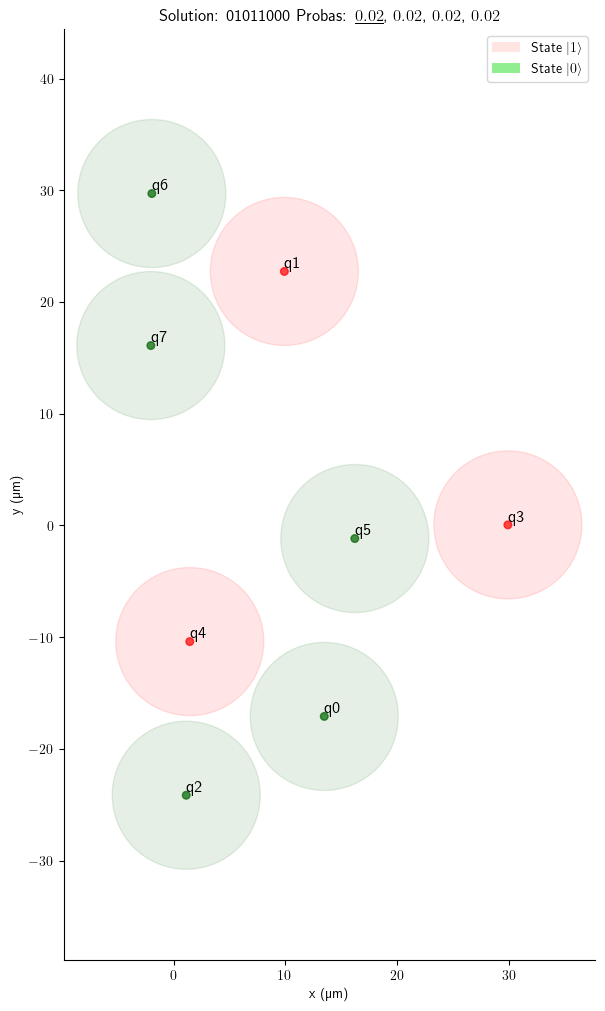

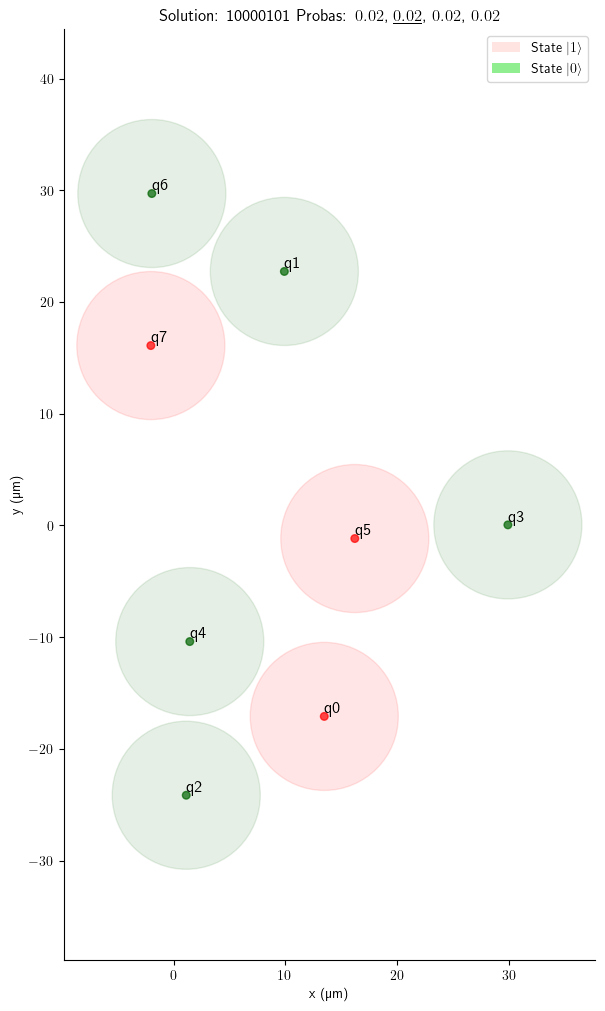

In [274]:
# divide Q by a value to not have atoms touch (in Rydberg blockade)
# does not change the solution
normalization = 2.5
coords, res = get_register_embedding(Q/normalization, seed=4, lossf="mae", device=DigitalAnalogDevice, ignore_warnings=True)
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}

reg = Register(qubits)
Omega = 0.3
delta_i = -1.0 
delta_f = -delta_i
T = 8_000  # time in ns
count_dict = anneal(reg, Omega, delta_i, delta_f, T)

# plotting
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:2]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
plot_distribution(count_dict, solutions_strs, show=False)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals)), res_vals, c="blue")
plt.show()
draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True)